In [77]:
%matplotlib inline
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
from matplotlib import pyplot as plt
from tqdm import trange
import numpy as np
dev = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(69)
dev

'cuda'

tensor(0)

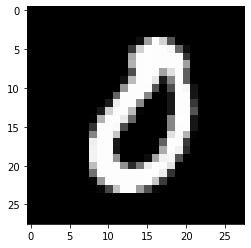

In [78]:
train_dtset = MNIST(
    root='./dataset',
    transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize([.5], [.5])]),
    download=True,
    train=True
)
test_dtset = MNIST(
    root='./dataset',
    transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize([.5], [.5])]),
    download=True,
    train=False
)
BS = 64
train_dtld = DataLoader(train_dtset, batch_size=BS, shuffle=True, drop_last=True)
test_dtld = DataLoader(test_dtset, batch_size=128, shuffle=True, drop_last=True)
a = next(iter(train_dtld))
plt.imshow(a[0][0,0], cmap='gray')
a[1][0]

In [30]:
class PrintShape(nn.Module):
    def __init__(self):
        super(PrintShape, self).__init__()
    def forward(self, x):
        print(x.shape)
        return x

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        def block(in_c, out_c, bn=True):
            b = [nn.Conv2d(in_c, out_c, 3, 2, 1), nn.LeakyReLU(.2, inplace=True), nn.Dropout2d(0.25)]
            if bn:
                b.append(nn.BatchNorm2d(out_c, .8))
            return b

        self.m = nn.Sequential(
            *block(1, 16, bn=False),
            *block(16, 32),
            *block(32, 64),
            *block(64, 128)
        )
        self.l = nn.Sequential(
            nn.Linear(512, 1),
            nn.Sigmoid()
        )
        self.flat = nn.Flatten()
    def forward(self, x):
        x = self.m(x)
        x = self.flat(x)
        return self.l(x)

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        def block(in_c, out_c):
            b = [
                nn.Upsample(scale_factor=2),
                nn.Conv2d(in_c, out_c, 3, stride=1, padding=1),
                nn.BatchNorm2d(out_c, 0.8),
                nn.LeakyReLU(0.2, inplace=True)
            ]
            return b
        self.l1 = nn.Linear(100, 128*7*7)
        self.res = lambda x: x.view((-1, 128, 7, 7))
        self.conv = nn.Sequential(
            nn.BatchNorm2d(128),
            *block(128, 128),
            *block(128, 64),
            nn.Conv2d(64, 1, 3, stride=1, padding=1),
            nn.Tanh(),
        )
    def forward(self, x):
        x = self.l1(x)
        x = self.res(x)
        return self.conv(x)

g = Generator().to(dev)
d = Discriminator().to(dev)
g_losses = []
d_losses = []
d(g(torch.randn((BS, 100), device=dev))).shape
# g(torch.randn((BS, 100), device=dev)).shape

torch.Size([64, 1])

In [31]:
def train_test_loop(dtld, train=True):
    g_step_losses = []
    d_step_losses = []

    for i, (x, _) in enumerate(dtld):
        x = x.to(dev)

        z = (torch.randn((BS, 100), device=dev) - .5) / .5
        ones, zeros = torch.ones((BS), device=dev), torch.zeros((BS), device=dev)
        gen_imgs = g(z)
        
        # Train generator
        for p in g.parameters():
            p.grad = None
        y_hat = d(gen_imgs).reshape((-1))
        g_loss = g_crit(y_hat, ones)
        g_loss.backward()
        g_optim.step()

        # Train discriminator
        for p in d.parameters():
            p.grad = None
        ones_hat, zeros_hat = d(x).reshape((-1)), d(gen_imgs.detach()).reshape((-1))
        d_loss = (d_crit(ones_hat, ones) + d_crit(zeros_hat, zeros)) / 2
        d_loss.backward()
        d_optim.step()
        
        g_losses.append(g_loss.item())
        d_losses.append(d_loss.item())

  0%|          | 0/200 [00:00<?, ?it/s]

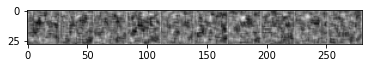

  0%|          | 1/200 [00:36<2:02:39, 36.98s/it]

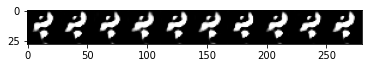

  1%|          | 2/200 [01:13<2:00:39, 36.57s/it]

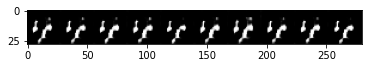

  2%|▏         | 3/200 [01:50<2:01:00, 36.85s/it]

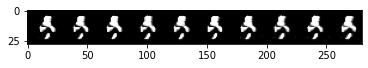

  2%|▏         | 4/200 [02:27<2:00:38, 36.93s/it]

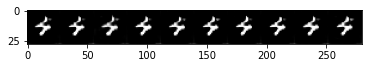

  2%|▎         | 5/200 [03:04<1:59:58, 36.91s/it]

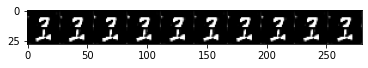

  3%|▎         | 6/200 [03:41<1:59:59, 37.11s/it]

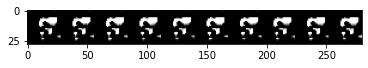

  4%|▎         | 7/200 [04:19<1:59:25, 37.13s/it]

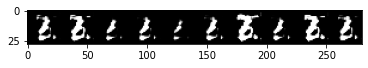

  4%|▍         | 8/200 [04:56<1:58:54, 37.16s/it]

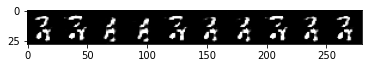

  4%|▍         | 9/200 [05:33<1:58:16, 37.16s/it]

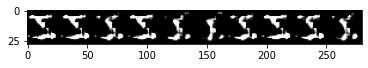

  5%|▌         | 10/200 [06:10<1:57:18, 37.05s/it]

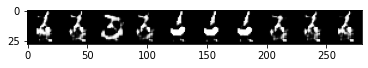

  6%|▌         | 11/200 [06:47<1:57:14, 37.22s/it]

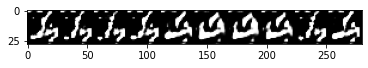

  6%|▌         | 12/200 [07:25<1:56:53, 37.31s/it]

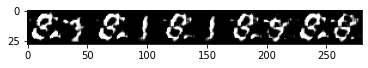

  6%|▋         | 13/200 [08:03<1:56:48, 37.48s/it]

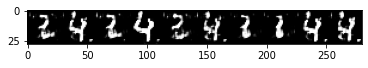

  7%|▋         | 14/200 [08:41<1:56:46, 37.67s/it]

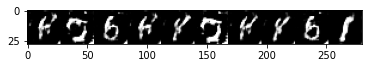

  8%|▊         | 15/200 [09:18<1:56:02, 37.64s/it]

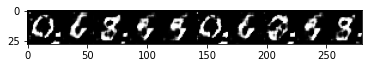

  8%|▊         | 16/200 [09:56<1:55:44, 37.74s/it]

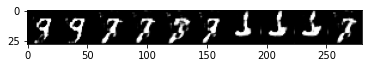

  8%|▊         | 17/200 [10:34<1:55:08, 37.75s/it]

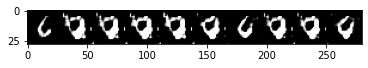

  9%|▉         | 18/200 [11:12<1:54:17, 37.68s/it]

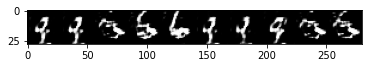

 10%|▉         | 19/200 [11:49<1:53:08, 37.51s/it]

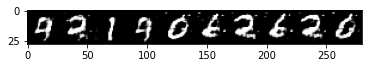

 10%|█         | 20/200 [12:26<1:52:12, 37.40s/it]

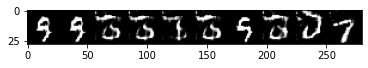

 10%|█         | 21/200 [13:03<1:51:44, 37.46s/it]

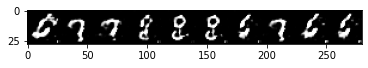

 11%|█         | 22/200 [13:41<1:51:08, 37.46s/it]

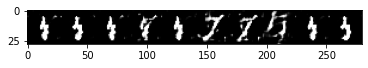

 12%|█▏        | 23/200 [14:19<1:50:43, 37.53s/it]

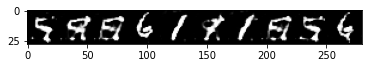

 12%|█▏        | 24/200 [14:56<1:50:08, 37.55s/it]

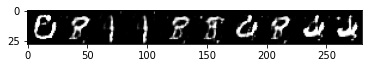

 12%|█▎        | 25/200 [15:34<1:49:22, 37.50s/it]

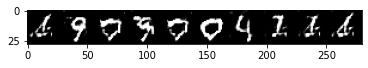

 13%|█▎        | 26/200 [16:11<1:48:45, 37.50s/it]

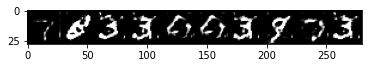

 14%|█▎        | 27/200 [16:48<1:47:32, 37.30s/it]

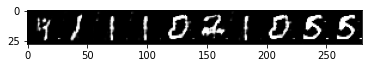

 14%|█▍        | 28/200 [17:26<1:47:17, 37.43s/it]

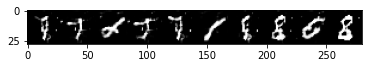

 14%|█▍        | 29/200 [18:04<1:47:22, 37.67s/it]

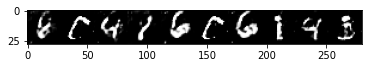

 15%|█▌        | 30/200 [18:41<1:46:18, 37.52s/it]

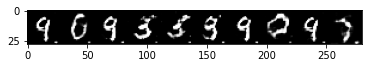

 17%|█▋        | 34/200 [21:08<1:41:51, 36.81s/it]

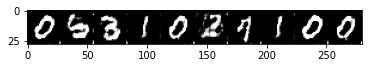

 18%|█▊        | 35/200 [21:45<1:41:35, 36.94s/it]

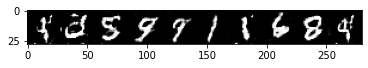

 18%|█▊        | 36/200 [22:22<1:40:49, 36.89s/it]

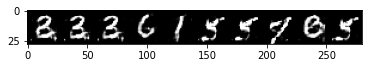

 18%|█▊        | 37/200 [22:59<1:40:33, 37.01s/it]

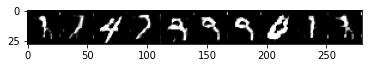

 19%|█▉        | 38/200 [23:36<1:40:07, 37.08s/it]

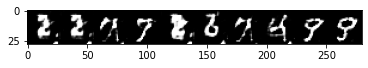

 20%|█▉        | 39/200 [24:13<1:38:57, 36.88s/it]

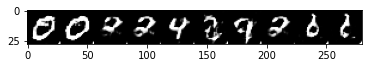

 20%|██        | 40/200 [24:50<1:38:35, 36.97s/it]

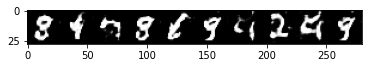

 20%|██        | 41/200 [25:27<1:38:19, 37.10s/it]

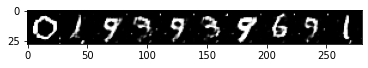

 21%|██        | 42/200 [26:05<1:38:26, 37.38s/it]

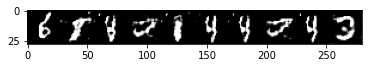

 22%|██▏       | 43/200 [26:43<1:37:51, 37.40s/it]

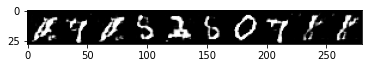

 22%|██▏       | 44/200 [27:21<1:37:36, 37.54s/it]

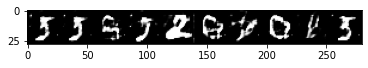

 22%|██▎       | 45/200 [27:58<1:36:39, 37.42s/it]

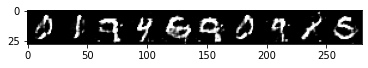

 23%|██▎       | 46/200 [28:35<1:36:04, 37.43s/it]

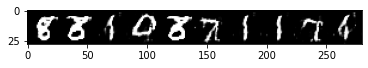

 24%|██▎       | 47/200 [29:12<1:34:58, 37.25s/it]

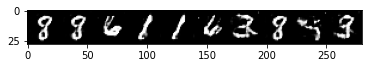

 24%|██▍       | 48/200 [29:50<1:34:30, 37.31s/it]

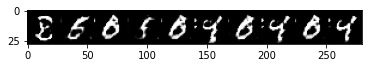

 24%|██▍       | 49/200 [30:26<1:33:21, 37.09s/it]

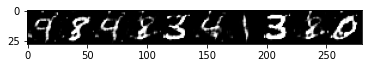

 25%|██▌       | 50/200 [31:03<1:32:41, 37.08s/it]

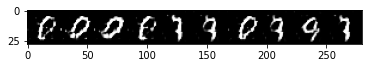

 26%|██▌       | 51/200 [31:41<1:32:42, 37.34s/it]

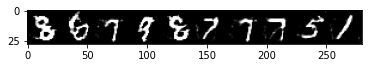

 26%|██▌       | 52/200 [32:18<1:31:46, 37.21s/it]

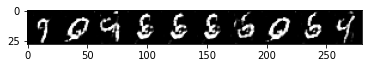

 26%|██▋       | 53/200 [32:55<1:30:57, 37.13s/it]

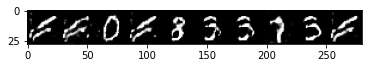

 27%|██▋       | 54/200 [33:32<1:30:20, 37.13s/it]

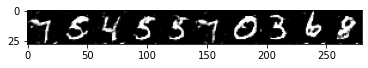

 28%|██▊       | 55/200 [34:09<1:29:41, 37.11s/it]

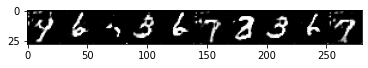

 28%|██▊       | 56/200 [34:47<1:29:34, 37.32s/it]

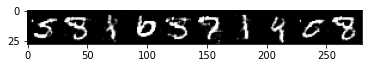

 28%|██▊       | 57/200 [35:25<1:29:01, 37.35s/it]

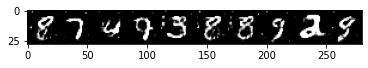

 29%|██▉       | 58/200 [36:02<1:28:28, 37.39s/it]

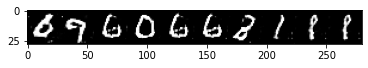

 30%|██▉       | 59/200 [36:40<1:28:16, 37.56s/it]

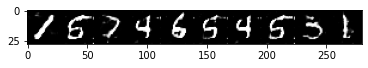

 30%|███       | 60/200 [37:18<1:27:45, 37.61s/it]

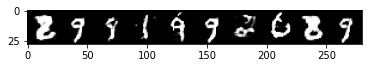

 30%|███       | 61/200 [37:56<1:27:20, 37.70s/it]

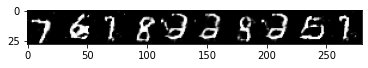

 31%|███       | 62/200 [38:33<1:26:47, 37.73s/it]

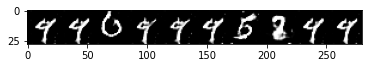

 32%|███▏      | 63/200 [39:11<1:25:52, 37.61s/it]

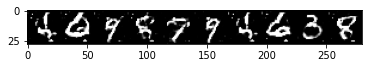

 32%|███▏      | 64/200 [39:49<1:25:35, 37.76s/it]

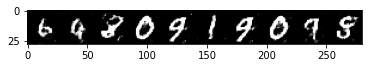

 32%|███▎      | 65/200 [40:27<1:25:05, 37.82s/it]

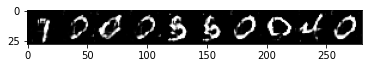

 33%|███▎      | 66/200 [41:04<1:24:09, 37.68s/it]

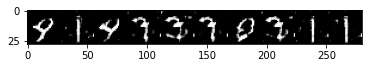

 34%|███▎      | 67/200 [41:42<1:23:30, 37.67s/it]

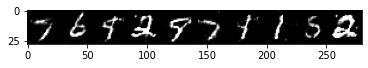

 34%|███▍      | 68/200 [42:19<1:22:32, 37.52s/it]

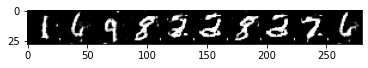

 34%|███▍      | 69/200 [42:56<1:21:42, 37.42s/it]

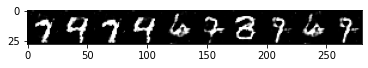

 35%|███▌      | 70/200 [43:34<1:21:04, 37.42s/it]

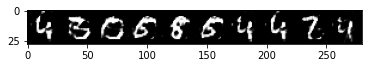

 36%|███▌      | 71/200 [44:11<1:20:35, 37.49s/it]

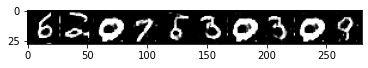

 36%|███▌      | 72/200 [44:48<1:19:49, 37.42s/it]

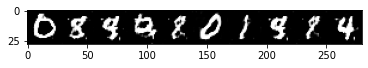

 36%|███▋      | 73/200 [45:26<1:19:10, 37.40s/it]

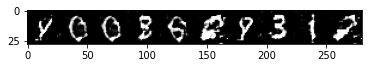

 37%|███▋      | 74/200 [46:03<1:18:12, 37.24s/it]

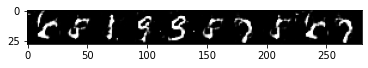

 38%|███▊      | 75/200 [46:40<1:17:48, 37.35s/it]

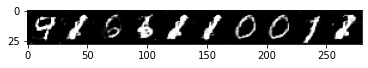

 38%|███▊      | 76/200 [47:18<1:17:08, 37.33s/it]

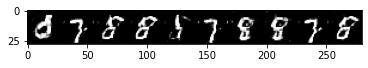

 38%|███▊      | 77/200 [47:55<1:16:38, 37.39s/it]

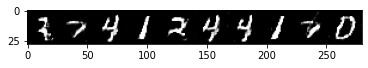

 39%|███▉      | 78/200 [48:32<1:16:01, 37.39s/it]

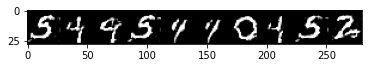

 40%|███▉      | 79/200 [49:10<1:15:14, 37.31s/it]

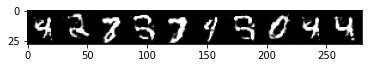

 40%|████      | 80/200 [49:47<1:14:27, 37.23s/it]

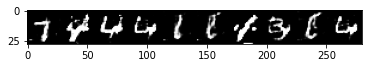

 40%|████      | 81/200 [50:24<1:13:39, 37.14s/it]

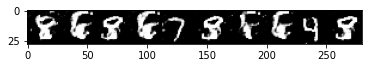

 41%|████      | 82/200 [51:01<1:13:07, 37.18s/it]

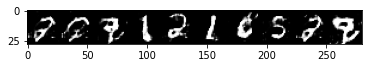

 42%|████▏     | 83/200 [51:38<1:12:31, 37.19s/it]

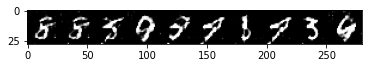

 42%|████▏     | 84/200 [52:16<1:12:11, 37.34s/it]

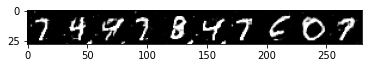

 42%|████▎     | 85/200 [52:53<1:11:42, 37.41s/it]

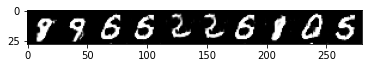

 43%|████▎     | 86/200 [53:30<1:10:39, 37.18s/it]

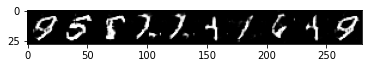

 44%|████▎     | 87/200 [54:05<1:08:41, 36.48s/it]

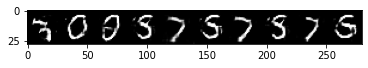

 44%|████▍     | 88/200 [54:40<1:07:33, 36.19s/it]

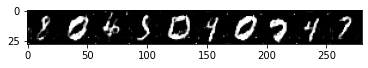

 44%|████▍     | 89/200 [55:15<1:06:18, 35.84s/it]

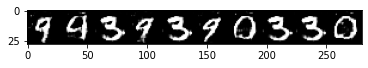

 45%|████▌     | 90/200 [55:50<1:05:14, 35.59s/it]

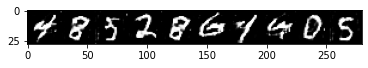

 46%|████▌     | 91/200 [56:25<1:04:13, 35.35s/it]

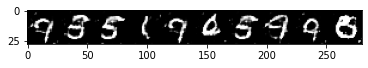

 46%|████▌     | 92/200 [57:00<1:03:20, 35.19s/it]

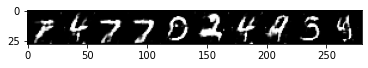

 46%|████▋     | 93/200 [57:35<1:02:30, 35.05s/it]

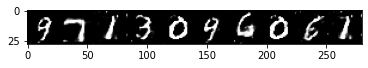

 47%|████▋     | 94/200 [58:10<1:01:47, 34.98s/it]

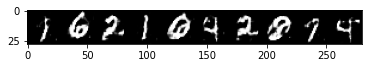

 48%|████▊     | 95/200 [58:46<1:01:58, 35.42s/it]

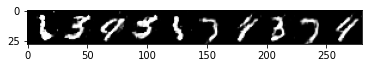

 48%|████▊     | 96/200 [59:21<1:01:12, 35.32s/it]

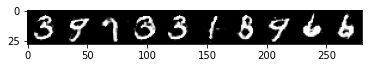

 48%|████▊     | 97/200 [59:56<1:00:23, 35.18s/it]

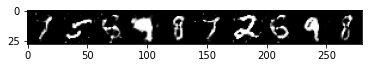

 49%|████▉     | 98/200 [1:00:32<1:00:13, 35.43s/it]

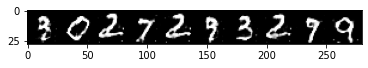

 50%|████▉     | 99/200 [1:01:07<59:18, 35.24s/it]  

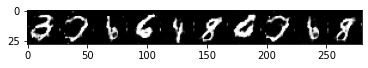

 50%|████▉     | 99/200 [1:01:37<1:02:52, 37.35s/it]


KeyboardInterrupt: 

In [34]:
g_crit = nn.BCELoss()
d_crit = nn.BCELoss()
g_optim = torch.optim.Adam(g.parameters(), lr=2e-4, betas=(.5, .999))
d_optim = torch.optim.Adam(d.parameters(), lr=2e-4, betas=(.5, .999))

epochs = 200

for epoch in trange(epochs):
    plt.imshow(np.concatenate(
        g((torch.randn((BS, 100), device=dev) - .5) / .5)[:10,0].cpu().detach().numpy(), axis=1), cmap='gray')
    plt.show()
    save()
    train_test_loop(train_dtld)

In [15]:
checkpoint = torch.load('checkpoint.pth')
load = False
if load:
    g.load_state_dict(checkpoint['g_state_dict'])
    d.load_state_dict(checkpoint['d_state_dict'])
    g_optim.load_state_dict(checkpoint['g_optim_state_dict'])
    d_optim.load_state_dict(checkpoint['d_optim_state_dict'])
    g_losses = checkpoint['g_losses']
    d_losses = checkpoint['d_losses']

In [33]:
def save():
    torch.save({
                'epoch': epoch,
                 'g_state_dict': g.state_dict(),
                'd_state_dict': d.state_dict(),
                'g_optim_state_dict': g_optim.state_dict(),
                'd_optim_state_dict': d_optim.state_dict(),
                'g_losses': g_losses,
                'd_losses': d_losses,
                }, 'checkpoint.pth')
save()

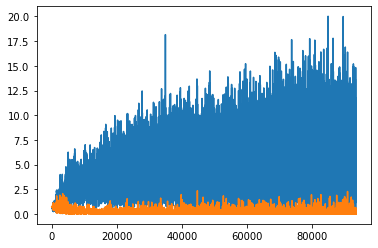

In [82]:
plt.plot(g_losses, label='Generator losses')
plt.plot(d_losses, label='Discriminator losses')
plt.show()

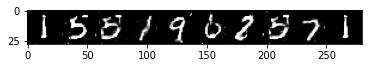

In [76]:
g.train()
plt.imshow(np.concatenate(
        g((torch.randn((BS, 100), device=dev) - .5) / .5)[:10,0].cpu().detach().numpy(), axis=1), cmap='gray')
plt.show()